**1. Load the data**

In [ ]:
!pip install pmdarima

In [201]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [169]:
df = pd.read_csv('/content/IPG2211A2N.csv')

In [170]:
df.shape

(1026, 2)

In [171]:
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3336
1,1939-02-01,3.3591
2,1939-03-01,3.4354
3,1939-04-01,3.4608
4,1939-05-01,3.4608


**2. Data Preprocessing**

In [172]:
# checking the null values
df.isna().sum()

,0
DATE,0
IPG2211A2N,0


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1026 non-null   object 
 1   IPG2211A2N  1026 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


In [174]:
#converting the 'DATE' col dtype to 'datetime'
df['DATE'] = pd.to_datetime(df['DATE'])

In [175]:
# making the 'DATE' col as index
df.set_index('DATE', inplace = True)

In [176]:
df.head()

,IPG2211A2N
DATE,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4608
1939-05-01,3.4608


**3. Checking the Stationarity of data**

<Axes: xlabel='DATE'>

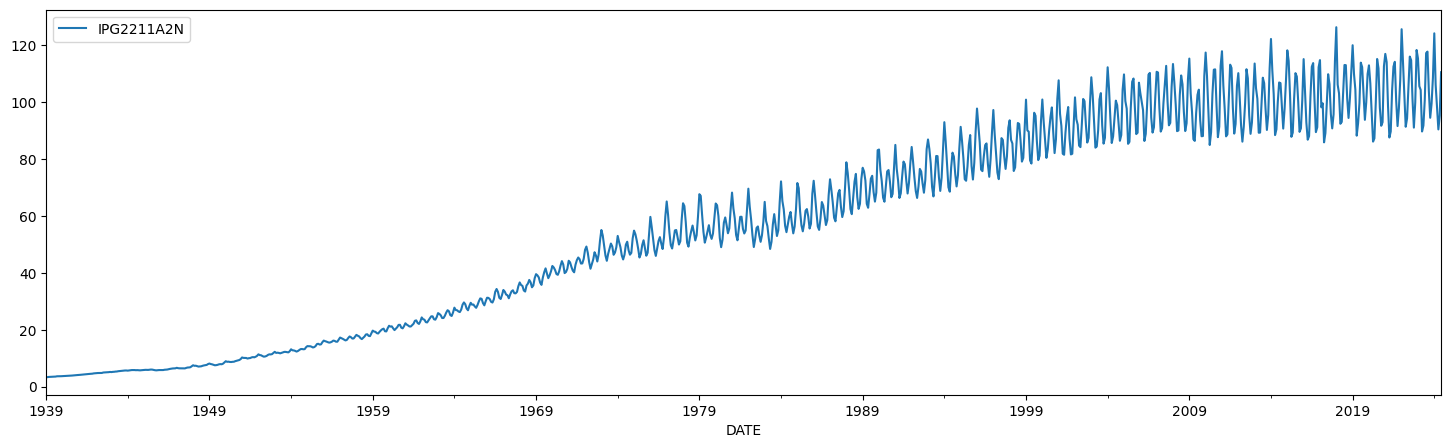

In [177]:
df.plot(figsize=(18, 5))

In [178]:
# Augmented Dickey Fuller test
def adf_test(data):
  result = adfuller(data)
  print(f'ADF Statistic : {result[0]}')
  print(f'p-value : {result[1]}')
  if result[1] <= 0.05:
    print('Reject the Null Hypothesis - Data is Stationary')
  else:
    print('Accept the Null Hypothesis - Data is not stationary')

adf_test(df.values)

ADF Statistic : -0.6881631132022455
p-value : 0.8497917806318546
Accept the Null Hypothesis - Data is not stationary


In [179]:
#First Order Differnencing
df['First_Order'] = df['IPG2211A2N'].diff()

In [180]:
df.dropna(inplace = True)

In [181]:
df.head()

,IPG2211A2N,First_Order
DATE,,
1939-02-01,3.3591,0.0255
1939-03-01,3.4354,0.0763
1939-04-01,3.4608,0.0254
1939-05-01,3.4608,0.0000
1939-06-01,3.5117,0.0509


In [182]:
adf_test(df['First_Order'])

ADF Statistic : -10.330269747104389
p-value : 2.854564945428982e-18
Reject the Null Hypothesis - Data is Stationary


<Axes: xlabel='DATE'>

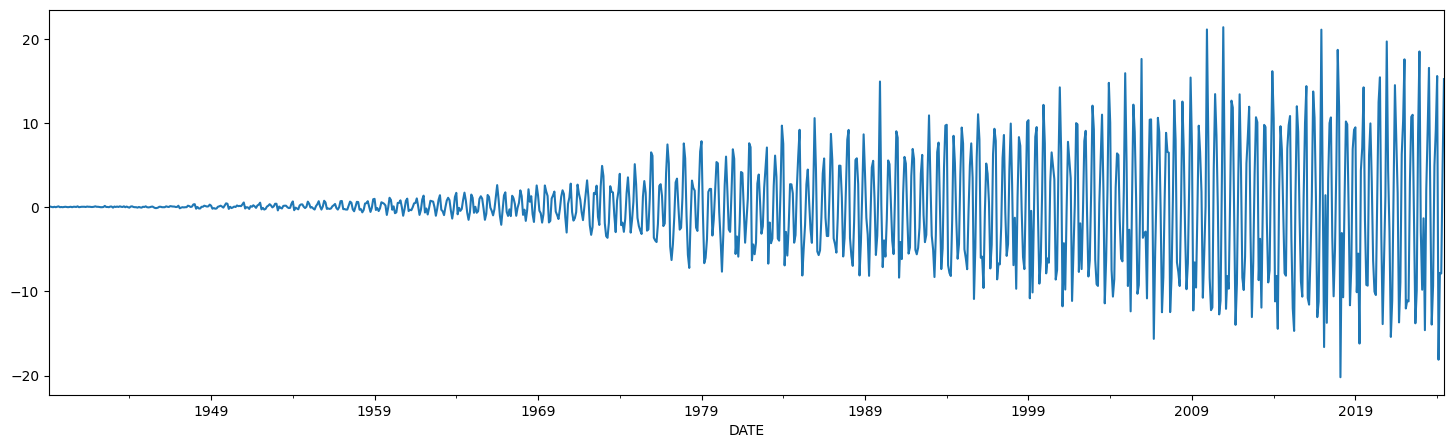

In [183]:
df['First_Order'].plot(figsize=(18, 5))

**4. Train Test Split**

In [184]:
0.8 * len(df)

820.0

In [185]:
train = df[['First_Order']][:820]
test = df[['First_Order']][820:]

In [186]:
train.shape, test.shape

((820, 1), (205, 1))

**5. Determine the ARIMA parameters - p,d,q**

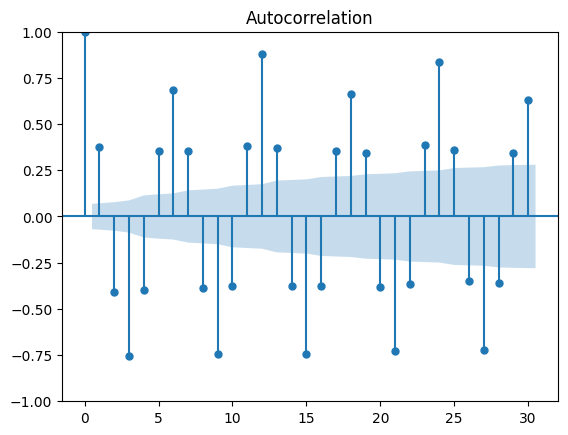

In [187]:
#acf plot - q
acf = plot_acf(train.values)

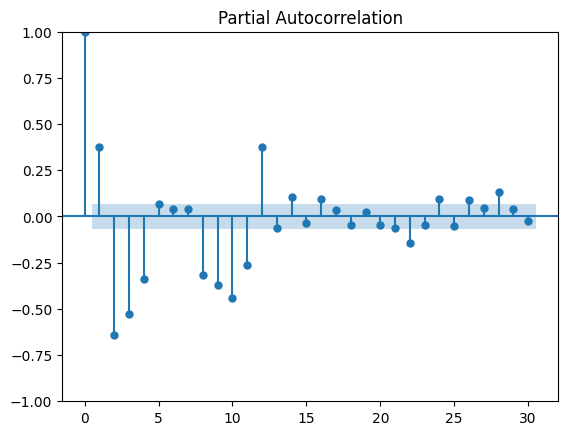

In [188]:
#pacf plot - p
pacf = plot_pacf(train.values)

In [189]:
autoArima = auto_arima(train, seasonal=False)

In [190]:
print(autoArima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  820
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1752.422
Date:                Sun, 11 Aug 2024   AIC                           3514.843
Time:                        06:28:26   BIC                           3538.390
Sample:                    02-01-1939   HQIC                          3523.878
                         - 05-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.001    933.917      0.000       0.998       1.002
ar.L2         -0.9996      0.001  -1586.927      0.000      -1.001      -0.998
ma.L1         -1.0342      0.009   -112.700      0.0

**6. Building the ARIMA model**

In [ ]:
model = ARIMA(train, order = autoArima.order)

<Axes: xlabel='DATE'>

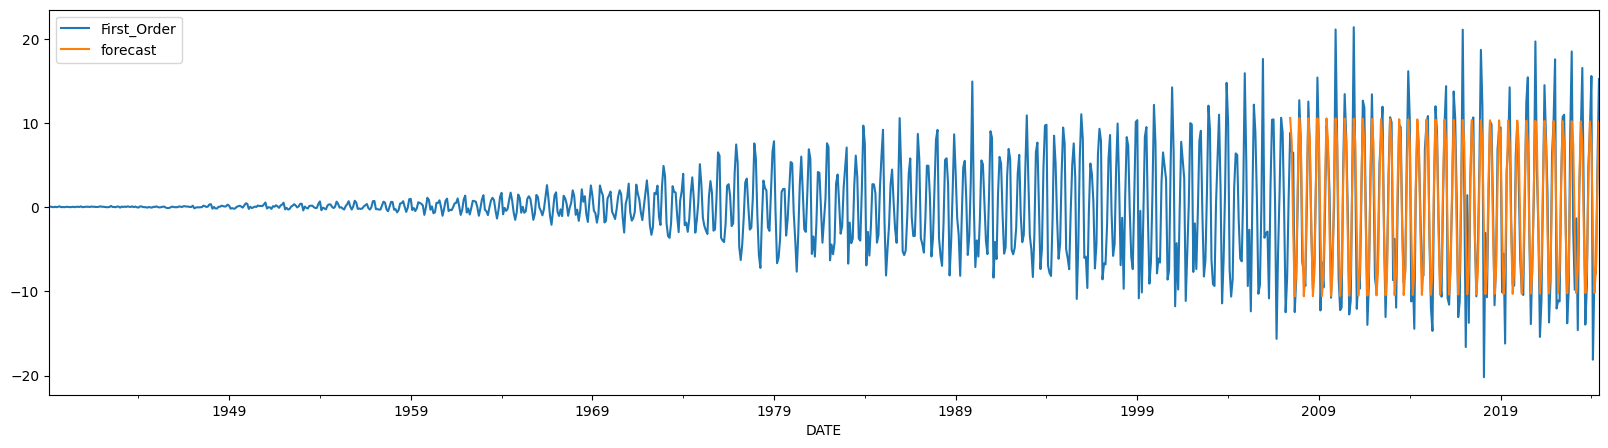

In [192]:
forecast = autoArima.predict(n_periods = len(test))

df['forecast'] = [None]*len(train) + list(forecast)

df[['First_Order', 'forecast']].plot(figsize=(20, 5))

In [195]:
df.head()

,IPG2211A2N,First_Order,forecast
DATE,,,
1939-02-01,3.3591,0.0255,NaN
1939-03-01,3.4354,0.0763,NaN
1939-04-01,3.4608,0.0254,NaN
1939-05-01,3.4608,0.0000,NaN
1939-06-01,3.5117,0.0509,NaN


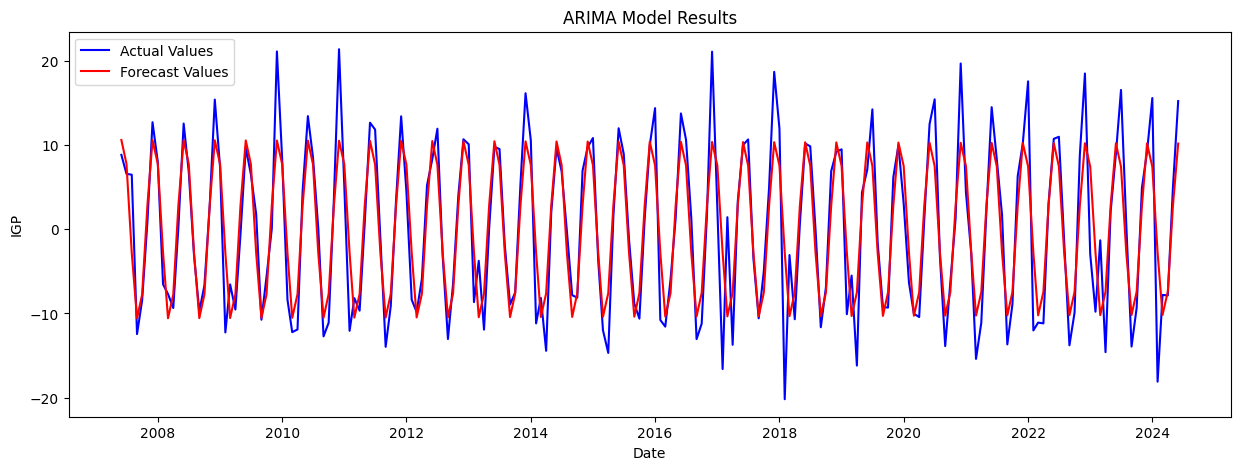

In [197]:
#plotting the test results

plt.figure(figsize = (15, 5))
plt.plot(df['First_Order'][820:], color = 'blue', label = 'Actual Values')
plt.plot(df['forecast'][820:], color = 'red', label = 'Forecast Values')
plt.title('ARIMA Model Results')
plt.xlabel('Date')
plt.ylabel('IGP')
plt.legend()

In [202]:
#evaluating metrics
mae = mean_absolute_error(df['First_Order'][820:], df['forecast'][820:])
rmse = np.sqrt(mean_squared_error(df['First_Order'][820:], df['forecast'][820:]))

print(f'Mean Absolute Error (MAE) : {mae}')
print(f'Root Mean Square Error (RMSE) : {rmse}')

Mean Absolute Error (MAE) : 3.287935428547524
Root Mean Square Error (RMSE) : 4.487485022677574
